In [1]:
#importing the libraries that we need here
import pandas as pd
import numpy as np 
from pandas.api.types import CategoricalDtype
from datetime import datetime 
import pandas as pd
import numpy as np 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

## movies metadata file cleaning

In [2]:
#loading the movie info table into a pandas dataframe
movies_df = pd.read_csv("Data/movies_metadata.csv")

/var/folders/j1/rhs6cm1s6r33j2qkcxx0f8kr0000gn/T/ipykernel_3139/2760051603.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv("Data/movies_metadata.csv")


Checking out the shape of the dataframe:

In [3]:
movies_df.shape

(45466, 24)

around 45k rows(movies) and 24 features for the movie description.

In [56]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Dropping the columns that we're not going to use

In [5]:
data_df = movies_df.drop(columns = ["adult","belongs_to_collection","homepage" ,"tagline","status","production_companies","production_countries",
                         "revenue","video","imdb_id","budget","poster_path"] , inplace= False)

In [6]:
data_df.isnull().sum()

genres                 0
id                     0
original_language     11
original_title         0
overview             954
popularity             5
release_date          87
runtime              263
spoken_languages       6
title                  6
vote_average           6
vote_count             6
dtype: int64

### Dealing appropriatly with the null values in the columns


Replacing the nulls in `vote` columns with 0.

In [7]:
data_df[data_df['vote_average'].isnull()] = 0
data_df[data_df['vote_count'].isnull()] = 0

In [8]:
data_df.isnull().sum()

genres                 0
id                     0
original_language     11
original_title         0
overview             954
popularity             0
release_date          84
runtime              257
spoken_languages       0
title                  0
vote_average           0
vote_count             0
dtype: int64

In [9]:
data_df.isnull().sum()

genres                 0
id                     0
original_language     11
original_title         0
overview             954
popularity             0
release_date          84
runtime              257
spoken_languages       0
title                  0
vote_average           0
vote_count             0
dtype: int64

Replacing the null values in `overview` column with title:

In [10]:
data_df['overview']= data_df['overview'].fillna(data_df['title'])

Replacing the null values in `runtime` column with the average runtime of the movies:

In [11]:
data_df[data_df['runtime'].isnull()] = data_df['runtime'].mean()

In [12]:
data_df.isnull().sum()

genres                0
id                    0
original_language    11
original_title        0
overview              0
popularity            0
release_date         73
runtime               0
spoken_languages      0
title                 0
vote_average          0
vote_count            0
dtype: int64

In [13]:
data_df["original_language"] = data_df['original_language'].fillna(data_df.spoken_languages[1])


In [14]:
data_df.isnull().sum()

genres                0
id                    0
original_language     0
original_title        0
overview              0
popularity            0
release_date         73
runtime               0
spoken_languages      0
title                 0
vote_average          0
vote_count            0
dtype: int64

Below: I'm going to convert the `release date` columns into `datetime` format.

In [15]:
data_df = data_df[pd.to_datetime(data_df["release_date"],errors='coerce').notnull()]
data_df['release_date'] = pd.to_datetime(data_df['release_date'])


In [16]:
#sanity check on data types
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45130 entries, 0 to 45465
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genres             45130 non-null  object        
 1   id                 45130 non-null  object        
 2   original_language  45130 non-null  object        
 3   original_title     45130 non-null  object        
 4   overview           45130 non-null  object        
 5   popularity         45130 non-null  object        
 6   release_date       45130 non-null  datetime64[ns]
 7   runtime            45130 non-null  float64       
 8   spoken_languages   45130 non-null  object        
 9   title              45130 non-null  object        
 10  vote_average       45130 non-null  float64       
 11  vote_count         45130 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 4.5+ MB


In [17]:
data_df[data_df['release_date'].isnull()] = data_df['release_date'].mean()

In [18]:
data_df.isnull().sum()

genres               0
id                   0
original_language    0
original_title       0
overview             0
popularity           0
release_date         0
runtime              0
spoken_languages     0
title                0
vote_average         0
vote_count           0
dtype: int64

In [19]:
#sanity check
data_df.isnull().sum()

genres               0
id                   0
original_language    0
original_title       0
overview             0
popularity           0
release_date         0
runtime              0
spoken_languages     0
title                0
vote_average         0
vote_count           0
dtype: int64

Converting `movieId` to int cause we're gonna use that later:

In [20]:
data_df['id'] = data_df['id'].astype('int64')

In [21]:
data_df.info() #sanity check

<class 'pandas.core.frame.DataFrame'>
Index: 45130 entries, 0 to 45465
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genres             45130 non-null  object        
 1   id                 45130 non-null  int64         
 2   original_language  45130 non-null  object        
 3   original_title     45130 non-null  object        
 4   overview           45130 non-null  object        
 5   popularity         45130 non-null  object        
 6   release_date       45130 non-null  datetime64[ns]
 7   runtime            45130 non-null  float64       
 8   spoken_languages   45130 non-null  object        
 9   title              45130 non-null  object        
 10  vote_average       45130 non-null  float64       
 11  vote_count         45130 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 4.5+ MB


Changing name of the `id` col to `movieID` so it has the same name as reveiw column: to join the review table with movies.

In [22]:
movies =data_df.rename(columns = {'id' : 'movieId'})
#our new dataframe dataframe that we're gonna work on 

#### Dropping the `genres` 
since it is a string and then creating a new `genre` as type of a list of genres.

In [23]:
movies['genres'] = movies['genres'].astype("str")
genre_list=[]
for genre in movies['genres']:
    genre = genre.strip("[").strip("]")
    genre_list.append(genre.split(','))
result = [] #list of lists


for i in range(len(genre_list)):
    
    ls=[] #list of dicts
    
    for item in genre_list[i]:
        temp = {}
        item = item.replace("'", "").replace("{", "").replace("}", "")
        if len(item.split(":"))==2:
            key, value = item.split(":")
            key = key.strip()
            value = value.strip()
            temp[key] = value
   
            ls.append(temp)
    result.append(ls)    

Creating a new column (`genre`) and putting the genres as a list of genres in it.

In [24]:
genres_names = []
for item in result:
    for dct in item:
        if 'name' not in dct.keys():
            item.remove(dct)
gen_list = []
for item in result:
    genres = []
    for dct in item:
        k,val = list(dct.items())[0]
        genres.append(val)
        
    gen_list.append(genres)
    
movies['genre']=gen_list

In [25]:
#dropping `genres` col
movies.drop(columns="genres" , inplace=True)

I'm going to convert the genres for the movies into binary format so we can workk with them.

Getting dummies for genres:

In [26]:
dummies_df  = pd.get_dummies(movies['genre'].explode()).groupby(level=0).sum()


In [27]:
dummies_df

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45460,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
45462,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
45463,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
45464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Concating the dummies to the movies dataframe:

In [28]:
movies = movies.join(dummies_df)

In [29]:
movies.isna().sum().sum()
#just checking for any nulls after the join

0

In [30]:
len(movies[movies['original_language'] == 'en'].values)
#checking the number of movies that have English as their first language

32197

In [31]:
# unique_genres = set()
# for genres_list in movies['genre']:
#     unique_genres.update(genres_list)

# # Convert the set of unique genres back to a list
# unique_genres = list(unique_genres)

# print(unique_genres)

['Animation', 'Drama', 'Crime', 'Action', 'History', 'Documentary', 'Thriller', 'Comedy', 'Mystery', 'Horror', 'TV Movie', 'Western', 'Fantasy', 'Foreign', 'War', 'Science Fiction', 'Family', 'Music', 'Romance', 'Adventure']


Now Let's see how many votes, movies have.

It would be rational to consider those who have at least a number of vote counts.

In [57]:
count_per_movie = movies.groupby(["vote_count"])['movieId'].count()


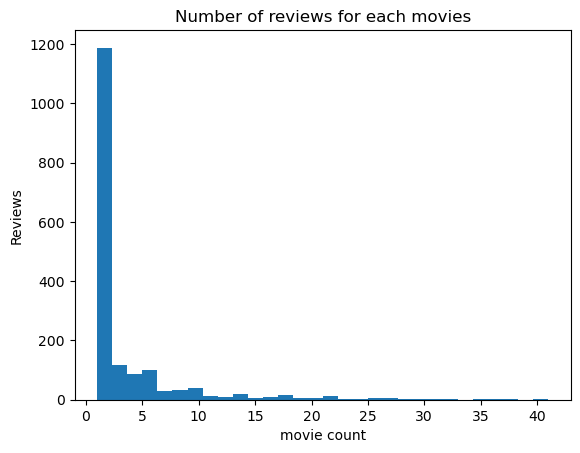

In [58]:
plt.figure()
plt.title("Number of reviews for each movies")
plt.hist(count_per_movie,bins=30)
plt.xlabel("movie count")
plt.ylabel("Reviews")
plt.show()

I'm gonna go with movies which have a vote higher than 100. (above 100 reviews)

In [34]:

filtered_df = movies[movies["vote_count"] > 100]
#This leaves us with 6k movies(which have above 100 reviews)
filtered_df
movies =filtered_df

In [35]:
# Select only the columns that have numeric data types
genres_df = movies.drop(movies.iloc[:, 1:13],axis=1,inplace=False)

In [36]:
genres_df.to_csv("Data/genres_dummies.csv")

In [59]:
movies.to_csv("Data/movies.csv")
#saving the movies dataframe that consist of 6k movies/ we're gonna do the filtering on these.

## ratings file cleaning

In [38]:
ratings_df = pd.read_csv("Data/ratings.csv")

In [39]:
ratings_df.head(2)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817


In [ ]:
#we're gonna drop the timestamp col since we're not gonna use it for anything
ratings_df.drop(columns = "timestamp", inplace=True)

Checking for any null values.

In [41]:
ratings_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [42]:
ratings_df

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0


In [43]:
ratings_df['liked'] =ratings_df['rating'].apply(lambda x: 1 if x > 3.5 else 0)


In [44]:
ratings_df

,userId,movieId,rating,liked
0,1,296,5.0,1
1,1,306,3.5,0
2,1,307,5.0,1
3,1,665,5.0,1
4,1,899,3.5,0
...,...,...,...,...
25000090,162541,50872,4.5,1
25000091,162541,55768,2.5,0
25000092,162541,56176,2.0,0
25000093,162541,58559,4.0,1


In [45]:
ratings_df.groupby("liked")['rating'].count()

liked
0    12547284
1    12452811
Name: rating, dtype: int64

The data is ditributed with balance, so there is no need to consider taking sample as an imblanced data.

Number of ratings is pretty huge. so I'm going to take a sample out of it. (~5%)

In [63]:
sample_ratings = ratings_df.sample(frac=0.05)

In [64]:
sample_ratings

,userId,movieId,rating,liked
12255027,79381,45186,4.0,1
23748393,154229,1436,1.0,0
19496323,126569,1259,4.0,1
11804786,76531,30793,3.5,0
20610516,134054,106489,2.5,0
...,...,...,...,...
7416855,48095,6461,4.0,1
12062546,78244,7570,1.0,0
6874691,44597,152081,4.5,1
3163034,20850,2794,4.0,1


### Take sample form Ratings:

Let's take a look at the number of movies each user has rated.

In [65]:
reviews_per_user=sample_ratings.groupby("userId").size()

It would be rational to use the reviewers who have at least a certain number of reviews on movies. Because we're going to user them in our 'user-item' matrix and 'user-user' matrix and our model would learn much better if the user has rated at least a certain number of movies rather than one.

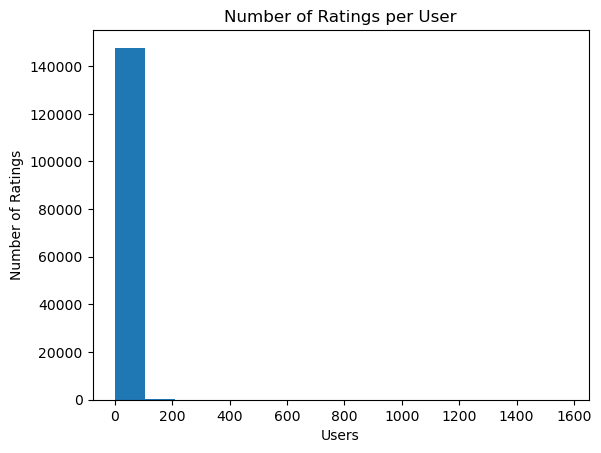

In [66]:

# Plot the number of ratings
plt.hist(reviews_per_user,bins=15)
plt.xlabel('Users')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per User')
plt.show()

I'm going to extract the users who have more than 10 reviews.

In [67]:
reviews_per_user = reviews_per_user[reviews_per_user>10]

In [68]:
reviews_per_user.index

Index([     3,      9,     12,     13,     19,     23,     31,     38,     43,
           57,
       ...
       162488, 162495, 162508, 162512, 162516, 162519, 162521, 162529, 162533,
       162534],
      dtype='int64', name='userId', length=32137)

In [69]:
sample_ratings =sample_ratings.sort_index()

In [70]:
sample_ratings = sample_ratings[sample_ratings['userId'].isin(reviews_per_user.index)]

In [71]:
sample_ratings

,userId,movieId,rating,liked
266,3,356,4.0,1
375,3,4167,3.5,0
381,3,4306,4.0,1
409,3,4979,4.0,1
439,3,5574,4.0,1
...,...,...,...,...
24999295,162534,122892,2.5,0
24999306,162534,136016,2.0,0
24999318,162534,152081,2.5,0
24999344,162534,174055,3.5,0


This leaves us with around 800k reviews for our filtering and modeling.

In [72]:

#im gonna save it in a csv file
sample_ratings.to_csv("Data/ratings_sample.csv",index=False)